<h1 style="color:skyblue;">Métodos de Clustering Basados en Particiones</h1>

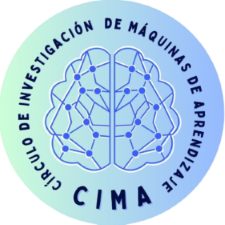

<h4 style="color:skyblue;">Alumna: Lucero Manrique Santos</h4>

El clustering es una técnica de aprendizaje no supervisado utilizada para agrupar datos similares. Entre los distintos enfoques, los métodos basados en particiones dividen los datos en un número fijo de clusters, buscando minimizar una función objetivo como la variabilidad intra-cluster.

Los algoritmos más representativos de este enfoque son:

- K-Means

- K-Medoids (PAM, CLARA)

- Fuzzy C-Means (FCM)

Características:

* Se requiere definir el número de clusters (k) de antemano.

* La asignación de datos a clusters busca minimizar la varianza intra-cluster.

* Algunos métodos permiten solapamiento entre clusters (Fuzzy C-Means).

<h2 style="color:skyblue;">K-Means</h2>




K-Means busca particionar los datos en k clusters minimizando la distancia cuadrática intra-cluster.

Algoritmo:

1. Se eligen k centroides iniciales aleatorios.

2. Se asigna cada punto al centroide más cercano.

3. Se recalculan los centroides como la media de los puntos asignados.

4. Se repiten los pasos 2 y 3 hasta convergencia.


<h3 style="color:skyblue;"> Caso 1: Segmentación de Clientes</h3>

**Columna	y descripción**

**InvoiceN**: Número de la factura asociada a la compra. Un cliente puede tener varias facturas.

**StockCode**: Código único del producto comprado.

**Description**: Descripción del producto adquirido.

**Quantity**: Cantidad de unidades compradas de un producto en una transacción.

**InvoiceDate**: Fecha y hora en la que se realizó la compra.

**UnitPrice**: Precio unitario del producto en la transacción.

**CustomerID**: Identificador único del cliente.

**Country**: País desde donde se realizó la compra.

**Fuente**: https://www.kaggle.com/datasets/yasserh/customer-segmentation-dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import seaborn as sns


<h4 style="color:skyblue;">Cargar datos</h4>

In [2]:
df = pd.read_excel("Online Retail.xlsx", engine="openpyxl")
print(df.head())

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  


<h4 style="color:skyblue;">Descripción</h4>

In [3]:
df.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [5]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [6]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

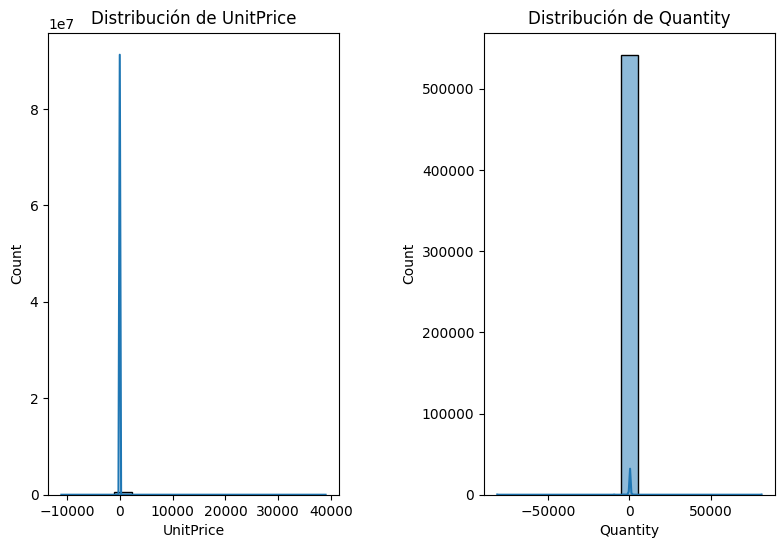

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(1, figsize=(15, 6))
n = 0 

for x in ['UnitPrice', 'Quantity']:
    n += 1
    plt.subplot(1, 3, n)
    plt.subplots_adjust(hspace=0.5, wspace=0.5)
    
    
    sns.histplot(df[x], bins=15, kde=True)
    
    plt.title(f'Distribución de {x}')
    
plt.show()


<h4 style="color:skyblue;">Pre-procesamiento</h4>

In [8]:
# Eliminar valores nulos en CustomerID
df = df.dropna(subset=['CustomerID'])

# Eliminar valores negativos en Quantity y UnitPrice
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

# Crear una nueva variable de TotalPrice
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# Agrupar por CustomerID y calcular métricas clave
grouped_df = df.groupby('CustomerID').agg(
    {
        'InvoiceNo': 'nunique',  
        'Quantity': 'sum',       
        'TotalPrice': 'sum'     
    }
)

# Renombrar columnas
grouped_df.columns = ['NumCompras', 'TotalProductos', 'TotalGastado']


# Escalar los datos

scaler = StandardScaler()
X_scaled = scaler.fit_transform(grouped_df)


<h4 style="color:skyblue;">Número óptimo de clusters usando el método del codo</h4>

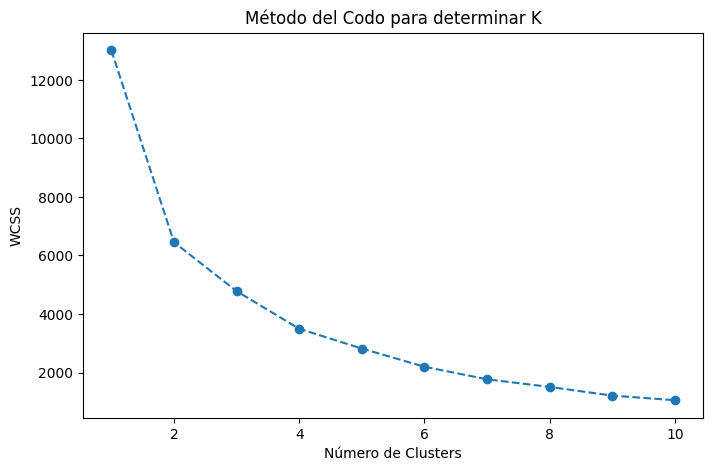

In [9]:
wcss = []
k_values = range(1, 11)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

# Graficar el método del codo
plt.figure(figsize=(8, 5))
plt.plot(k_values, wcss, marker='o', linestyle='--')
plt.xlabel('Número de Clusters')
plt.ylabel('WCSS')
plt.title('Método del Codo para determinar K')
plt.show()
# lo ideal es elegir el punto donde la curva deja de disminuir drásticamente y se empieza a suavizar.


<h4 style="color:skyblue;">Aplicar K-Means</h4>

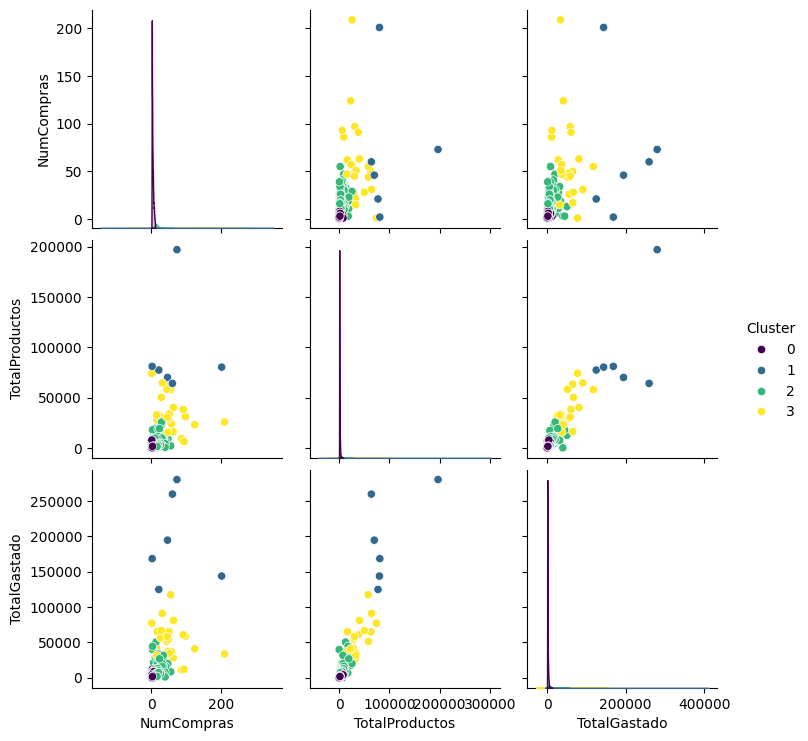

In [10]:
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
grouped_df['Cluster'] = kmeans.fit_predict(X_scaled)
centroids = kmeans.cluster_centers_
# Visualizar los clusters
sns.pairplot(grouped_df, hue='Cluster', palette='viridis')
plt.show()

In [11]:
# Mostrar estadísticos por cluster
print(grouped_df.groupby('Cluster').mean())


         NumCompras  TotalProductos   TotalGastado
Cluster                                           
0          2.817036      589.754284     986.517718
1         67.166667    94944.666667  195271.033333
2         16.394118     4199.385294    7604.762588
3         57.375000    34592.000000   51652.505000


<h4 style="color:skyblue;">Conclusión</h4>



**Cluster 0**: Compradores ocasionales, clientes individuales con pocas compras.

**Cluster 1**: Clientes VIP o distribuidores que compran en enormes volúmenes.

**Cluster 2**: Clientes frecuentes que gastan bastante, posiblemente negocios pequeños o consumidores fieles.

**Cluster 3**: Mayoristas o revendedores que compran grandes cantidades pero gastan menos que los VIP.

<h2 style="color:skyblue;">K-Medoids</h2>

Similar a K-Means, pero usa puntos reales del conjunto de datos como centroides, lo que lo hace más resistente a outliers.

Diferencias con K-Means:

En lugar de promediar los valores, selecciona puntos específicos como centroides.

Menos sensible a valores atípicos.

Datos ideales para K-Medoids:
1. Datos con outliers.
2. Clusters de forma esferoidal o ligeramente irregulares.
3. Datos categóricos o mixtos


<h3 style="color:skyblue;">Caso 2: Fraudes</h3>

Este conjunto de datos presenta transacciones que ocurrieron en dos días, donde tenemos 492 fraudes de 284.807 transacciones. El conjunto de datos está muy desequilibrado, la clase positiva (fraudes) representa el 0,172% de todas las transacciones.

Contiene únicamente variables de entrada numéricas que son el resultado de una transformación PCA. Desafortunadamente, debido a problemas de confidencialidad, no podemos proporcionar las características originales y más información de fondo sobre los datos. Las características V1, V2, … V28 son los componentes principales obtenidos con PCA, las únicas características que no se han transformado con PCA son 'Tiempo' y 'Cantidad'. La característica 'Tiempo' contiene los segundos transcurridos entre cada transacción y la primera transacción en el conjunto de datos. La característica 'Cantidad' es la cantidad de la transacción, esta característica se puede utilizar para el aprendizaje sensible al costo dependiente del ejemplo. La característica 'Clase' es la variable de respuesta y toma el valor 1 en caso de fraude y 0 en caso contrario.

**Fuente**: https://www.kaggle.com/code/rodmnzs/fraud-detection-clustering-with-dbscan

In [59]:
#!pip install scikit-learn-extra

In [12]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn_extra.cluster import KMedoids
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder


<h4 style="color:skyblue;">Lectura de datos</h4>

In [30]:
#K-Medoids es muy costoso en memoria para un conjunto de datos grande.

In [13]:
df = pd.read_csv("creditcard.csv")
df = df.sample(n=10000, random_state=2)  # Reducir a 10,000 registros
print(df.head())

            Time        V1        V2        V3        V4        V5        V6  \
225184  144140.0 -0.581460  0.950267  0.115938 -1.384767  1.388364 -1.595678   
116637   74369.0  0.686730 -0.785586  0.945092  1.476634 -1.191074 -0.193185   
99414    67107.0 -0.848395  1.214313  0.954869 -0.030145 -0.177527 -0.851855   
217619  140965.0 -1.104465  0.616952 -0.878973 -0.312839 -0.092112 -0.020623   
279878  169155.0  2.061985 -0.114758 -1.079406  0.427062 -0.229701 -1.241109   

              V7        V8        V9  ...       V21       V22       V23  \
225184  2.120867 -0.718954 -0.205211  ...  0.153480  0.656548 -0.514192   
116637 -0.217963 -0.011827  0.727172  ...  0.277960  0.419683 -0.314303   
99414   0.444232  0.369063 -1.005181  ...  0.205928  0.552455 -0.064845   
217619  1.422463  0.442278 -0.406603  ...  0.265005  0.438796  0.413781   
279878  0.121975 -0.283331  0.679923  ... -0.299538 -0.772333  0.352777   

             V24       V25       V26       V27       V28  Amount  Cl

In [14]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 225184 to 36601
Data columns (total 31 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Time    10000 non-null  float64
 1   V1      10000 non-null  float64
 2   V2      10000 non-null  float64
 3   V3      10000 non-null  float64
 4   V4      10000 non-null  float64
 5   V5      10000 non-null  float64
 6   V6      10000 non-null  float64
 7   V7      10000 non-null  float64
 8   V8      10000 non-null  float64
 9   V9      10000 non-null  float64
 10  V10     10000 non-null  float64
 11  V11     10000 non-null  float64
 12  V12     10000 non-null  float64
 13  V13     10000 non-null  float64
 14  V14     10000 non-null  float64
 15  V15     10000 non-null  float64
 16  V16     10000 non-null  float64
 17  V17     10000 non-null  float64
 18  V18     10000 non-null  float64
 19  V19     10000 non-null  float64
 20  V20     10000 non-null  float64
 21  V21     10000 non-null  float6

In [16]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,94297.219500,0.008417,-0.013281,0.031429,0.027998,0.019157,0.011276,-0.001685,0.004351,-0.000693,...,0.002318,-0.009622,-0.002162,-0.006019,-0.000038,0.000845,0.001179,-0.001237,89.181501,0.001500
std,47730.290851,1.926644,1.665735,1.500552,1.428482,1.360759,1.328418,1.190734,1.195801,1.089391,...,0.764582,0.728413,0.618312,0.604904,0.511917,0.484711,0.392549,0.273213,244.535969,0.038703
min,42.000000,-33.404082,-38.436817,-30.177317,-4.895064,-17.892600,-17.282140,-31.197329,-37.353443,-9.462573,...,-15.790142,-8.887017,-22.575000,-2.836627,-3.741618,-1.488437,-7.263482,-6.390338,0.000000,0.000000
25%,53607.500000,-0.897642,-0.600277,-0.847326,-0.836269,-0.670249,-0.748696,-0.534334,-0.207444,-0.633016,...,-0.226102,-0.542541,-0.157060,-0.360122,-0.316203,-0.330414,-0.070998,-0.053276,5.507500,0.000000
50%,84217.000000,-0.000252,0.064126,0.193266,0.004667,-0.051168,-0.269643,0.039940,0.022061,-0.051521,...,-0.031272,0.007509,-0.013279,0.036184,0.009852,-0.056162,0.001721,0.011657,22.370000,0.000000
75%,139434.500000,1.305372,0.780780,1.041371,0.782162,0.627767,0.430150,0.572285,0.317632,0.587308,...,0.176646,0.504095,0.147222,0.433735,0.347269,0.240314,0.093563,0.080130,76.292500,0.000000
max,172787.000000,2.361987,16.497472,3.836909,12.699542,28.516513,9.410864,18.585729,15.794136,7.937988,...,27.202839,4.295616,20.803344,3.521680,5.826159,2.834887,9.200883,4.484648,6900.470000,1.000000


In [17]:
df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

<h4 style="color:skyblue;">Preprocesamiento</h4>

In [18]:
# Seleccionar las características para clustering (excluimos 'Class')
features = df.drop(columns=['Class'])

# Escalar los datos para mejorar la calidad del clustering
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

<h4 style="color:skyblue;">Silhouette Score</h4>

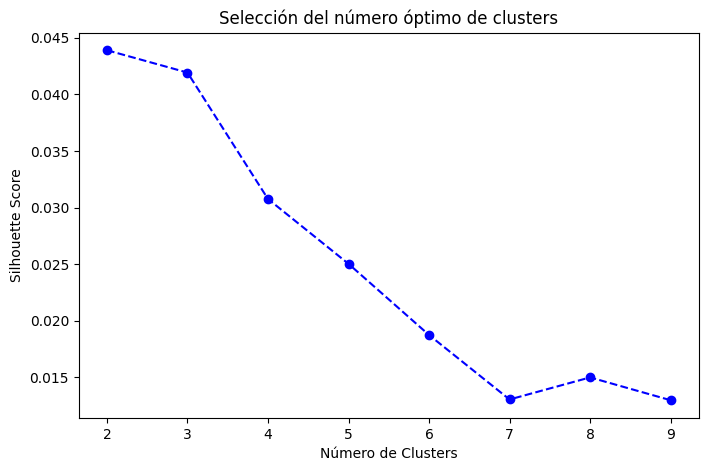

In [19]:
# Selección del número óptimo de clusters con Silhouette Score
silhouette_scores = []
k_values = range(2, 10)  # Probamos de 2 a 10 clusters
for k in k_values:
    kmedoids = KMedoids(n_clusters=k, random_state=42, metric='euclidean')
    labels = kmedoids.fit_predict(X_scaled)
    silhouette_scores.append(silhouette_score(X_scaled, labels))
    
# Graficar el Silhouette Score
plt.figure(figsize=(8, 5))
plt.plot(k_values, silhouette_scores, marker='o', linestyle='--', color='b')
plt.xlabel('Número de Clusters')
plt.ylabel('Silhouette Score')
plt.title('Selección del número óptimo de clusters')
plt.show()

<h2 style="color:skyblue;"> Aplicar K-Medoids </h2>

In [20]:
# Aplicar K-Medoids con el número óptimo de clusters
k_optimo = k_values[np.argmax(silhouette_scores)]
kmedoids = KMedoids(n_clusters=k_optimo, random_state=42, metric='euclidean')
df['Cluster'] = kmedoids.fit_predict(X_scaled)

<h2 style="color:skyblue;"> Visualización de los clusters </h2>

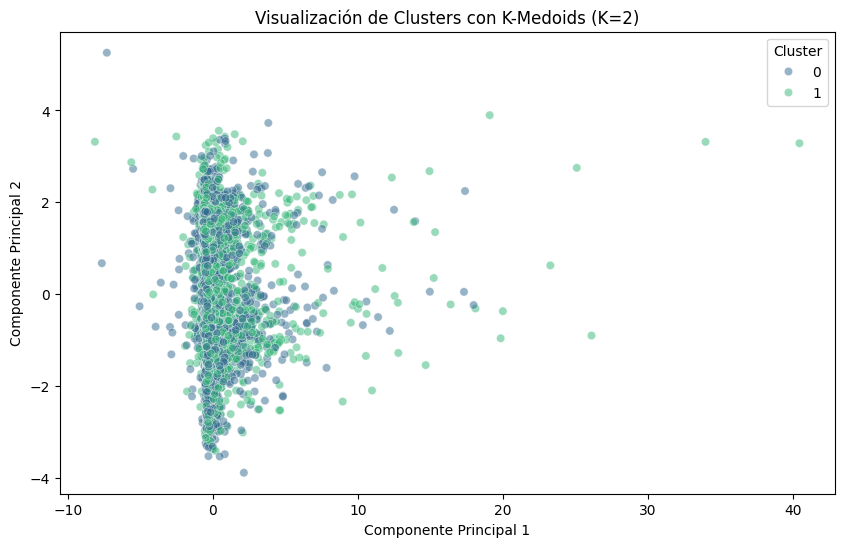

In [21]:
# usando PCA para reducir a 2D
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
df['PCA1'] = X_pca[:, 0]
df['PCA2'] = X_pca[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['PCA1'], y=df['PCA2'], hue=df['Cluster'], palette='viridis', alpha=0.5)
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title(f'Visualización de Clusters con K-Medoids (K={k_optimo})')
plt.legend(title='Cluster')
plt.show()

In [22]:
# Mostrar cuántas transacciones fraudulentas hay por cluster
fraud_counts = df.groupby('Cluster')['Class'].sum()
print("Cantidad de fraudes por cluster:")
print(fraud_counts)


Cantidad de fraudes por cluster:
Cluster
0    12
1     3
Name: Class, dtype: int64


Cluster 0: Alta probabilidad de fraude, transacciones con comportamientos atípicos, riesgos más altos.

Cluster 1: Menor cantidad de fraudes, comportamiento más cercano a lo normal, pero con algunos fraudes que siguen siendo relevantes.

<h2 style="color:skyblue;">Fuzzy C-Means</h2>

A diferencia de K-Means y K-Medoids, en FCM cada punto puede pertenecer a más de un cluster con un grado de pertenencia determinado por una función de membresía.

Ejemplo de aplicación:

Análisis de emociones en redes sociales.

Diagnóstico médico a partir de imagenología.

<h3 style="color:skyblue;">Caso 3: Clustering de Tweets</h3>

Un conjunto de datos de texto que contiene tweets de dos empresarios conocidos (Bill Gates y Elon Musk) y el ex alcalde de la ciudad de San Francisco (Ed Lee)

**Fuente**: https://www.kaggle.com/datasets/micheldc55/tweets-from-bill-gates-elon-musk-and-ed-lee/data?select=datos_tweets_BillGates.csv

In [23]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from skfuzzy.cluster import cmeans
import re
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt

In [24]:
df = pd.read_csv("datos_tweets_BillGates.csv")

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2087 entries, 0 to 2086
Data columns (total 35 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   screen_name                     2087 non-null   object 
 1   user_id                         2087 non-null   int64  
 2   created_at                      2087 non-null   object 
 3   status_id                       2087 non-null   float64
 4   text                            2087 non-null   object 
 5   retweet_count                   2087 non-null   int64  
 6   favorite_count                  2087 non-null   int64  
 7   is_quote_status                 2087 non-null   bool   
 8   quote_status_id                 22 non-null     float64
 9   is_retweet                      2087 non-null   bool   
 10  retweet_status_id               0 non-null      float64
 11  in_reply_to_status_status_id    47 non-null     float64
 12  in_reply_to_status_user_id      51

<h4 style="color:skyblue;"> Preprocesamiento</h4>

In [26]:
# Asegurar que la columna 'text' no tenga valores nulos y convertir a string
df['text'] = df['text'].fillna('').astype(str)

# Función de limpieza
def limpiar_texto(texto):
    texto = texto.lower()  # Convertir a minúsculas
    texto = re.sub(r'http\S+', '', texto)  # Eliminar URLs
    texto = re.sub(r'&amp;|&lt;|&gt;|&quot;', '', texto)  # Eliminar caracteres especiales
    texto = texto.strip()  # Eliminar espacios extra al inicio y al final
    return texto

# Aplicar la limpieza en una sola pasada
df['text'] = df['text'].apply(limpiar_texto)

# Convertir a lista si es necesario
documents = df['text'].tolist()

# Mostrar algunos ejemplos después del preprocesamiento
print(documents[:5])



['tanzania hopes to eliminate one of the world’s most painful diseases by 2020. from what i saw in this village, i’m…', 'by investing in rd, i know we can discover new innovations that will help wipe tuberculosis off the map:…', 'this unusual tool for fighting disease turns our old thinking about treatment on its head.', "my first trip to africa with melinda was the catalyst that began my #mygivingstory. what's yours:…", '“the death that didn’t happen is not visible." a fascinating conversation between @atul_gawande and @gladwell.']


<h4 style="color:skyblue;"> Aplicación Fuzzy C-Means </h4>

In [30]:
# Preprocesamiento: extracción de características TF-IDF
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(documents).toarray()  # Convertir a matriz densa

n_clusters = 4 # Número de clústeres
fuzzy_cmeans = cmeans(X.T, n_clusters, m=2, error=0.005, maxiter=1000)

# Matriz de membresía
membership_matrix = fuzzy_cmeans[1]

clusters = np.argmax(membership_matrix, axis=0)
#for i, doc in enumerate(documents):
    #print(f"El documento '{doc}' pertenece al clúster {clusters[i] + 1}")

<h4 style="color:skyblue;">Graficar los documentos según su clúster asignado</h4>

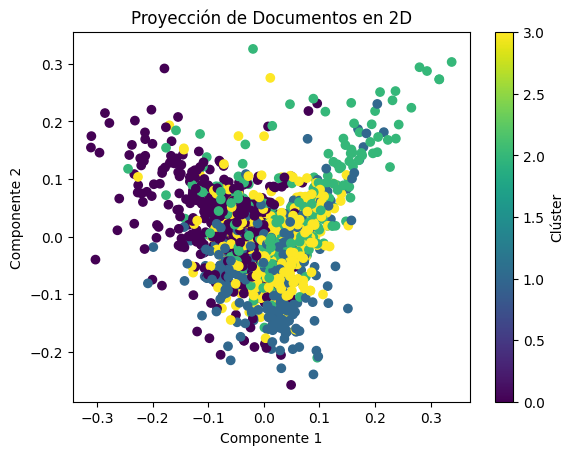

In [28]:
# Reducir la dimensionalidad a 2D con PCA
pca = PCA(n_components=2)
reduced_X = pca.fit_transform(X)


plt.scatter(reduced_X[:, 0], reduced_X[:, 1], c=clusters, cmap='viridis')
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.title('Proyección de Documentos en 2D')
plt.colorbar(label='Clúster')
plt.show()


In [29]:
for cluster_id in range(n_clusters):
    print(f"Clúster {cluster_id + 1}:")
    # Mostrar los tweets más cercanos a este clúster
    cluster_docs = [documents[i] for i in range(len(documents)) if clusters[i] == cluster_id]
    print("\n".join(cluster_docs[:5]))  # Mostrar los primeros 5 tweets de cada clúster
    print("\n")


Clúster 1:
tanzania hopes to eliminate one of the world’s most painful diseases by 2020. from what i saw in this village, i’m…
by investing in rd, i know we can discover new innovations that will help wipe tuberculosis off the map:…
science can make the world a better place – but only if we work together:
in 2007, small groups of hiv patients in mozambique decided to challenge the traditional approach to hiv treatment.…
we can’t address what we can’t measure. to end modern slavery, we need the best available data:…


Clúster 2:
.@johncena the polio expert? it's just one of this superstar’s many surprising talents:
there are few people i've learned more from than bill foege.
i haven’t heard many doctors talk about reducing their role in treatment. but when tom ellman speaks, people listen…
i visited @georgiastateu earlier this year and met an amazing group of students...
.@barackobama knows a thing or two about inspiring young people. we loved talking to him about how to empower other…


Clúster 1: Enfermedades Globales y Soluciones Innovadoras

Clúster 2: Líderes, Educación y Motivación

Clúster 3: Equidad en Educación y Salud Pública

Clúster 4: Impacto Social y Experiencias Personales